In [2]:
## Imports

import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm
import scipy as scp
import scipy.special
from numpy.fft import fftshift, ifftshift, ifft2, fftn, ifftn
import sigpy as sp
from sigpy.mri import dcf
import scipy.misc
from pynufft import NUFFT

### 1. Generate k-space analytically

In [ ]:
### Function: Generate k-space analytically
def generate_ksp_cylinder(a, h, size, kmax=0.5):
    '''Returns k-space of cylinder, generated from cylinder radius

    Inputs
    -------------------------
    a : float
        Radius of cylinder in xy-plane (pixels)
    h : float
        Height of cylinder along z-axis (pixels)
    size: int
        Number of points along each dimension for isotropic voxels
    fov: float
        Cubic field of view 

    Ouput
    ------------------
    3D array of k-space values for the cylinder
    
    '''

    ## Create k-space grid
    k_range = np.linspace(-kmax, kmax, size)
    KX, KY, KZ = np.meshgrid(k_range, k_range, k_range, indexing='ij')

    ## Transverse plane
    K_xy = np.sqrt(KX**2 + KY**2)
    K_xy[K_xy==0] = 1e-10  #in case of zero division

    F_xy = 2*np.pi*(a**2)*scipy.special.jv(1,K_xy*a)/(K_xy*a)
    F_z = np.sinc(KZ*h/(2*np.pi))*h

    ## Move z-component to be first axis
    F_k = np.swapaxes(F_xy*F_z, 0, 2)
    
    return F_k, kmax

def shift_pixels(F_k, kmax, shift_pixels_coord):

    '''Returns k-space of cylinder, with additional phase term to represent spatial shift 

    Inputs
    -------------------------
    F_k : ndarray
        3D k-space array, assume shape (Z, Y, X)

    shift_pixels : tuple
        length-2 tuple for in-plane spatial shift

    Ouput
    ------------------
    F_k_shifted :  ndarray
        3D array of k-space values for the cylinder with additional phase
    
    '''
    ## Deconstruct F_k into in-plane and z components
    size = F_k.shape[0]

    k_range = np.linspace(-kmax, kmax, size)
    KX, KY, KZ = np.meshgrid(k_range, k_range, k_range, indexing='ij')

    ## shift pixels should be x,y shift
    sx, sy = shift_pixels_coord
    phase = np.exp(-1j*2*np.pi*((sx*KX + sy*KY)))
    phase_2d = phase[:, :, 0][np.newaxis, :, :] 
    print(f'phase = {np.mean(phase)}')
    print(phase.shape)

    F_k_shifted = F_k * phase_2d
    ## Loop over z dimension, only apply additive phase in-plane
    # for z_idx in range(F_k.shape[0]):
    #     F_k_shifted[z_idx,:, :] = F_k[z_idx, :, :] * phase_2d
   
    return F_k_shifted


def plot_ksp_magnitude(ksp, z_slice=None):
    if z_slice==None:
        z_slice = ksp.shape[0]//2
    magnitude_spectrum = 20*np.log(np.abs(ksp[z_slice, :, :]))
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title(f'K-space magnitude | z slice = {z_slice}')
    plt.axis('off')
    plt.show()

phase = (0.007812499999999778+4.735795089416683e-16j)
(128, 128, 128)
ksp_cylinder.shape = (128, 128, 128)
ksp_cylinder_shifted.shape = (128, 128, 128)


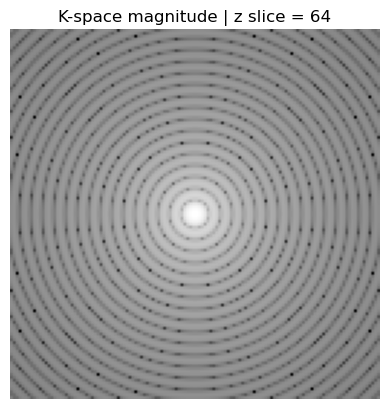

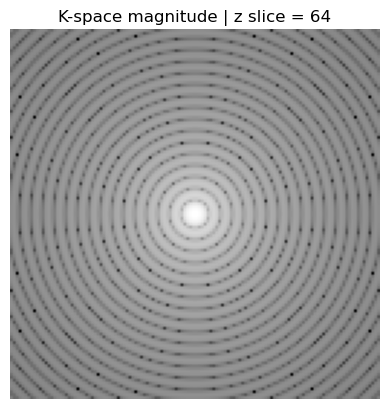

In [24]:
a = 100.0
h = 250.0
num_samples = 1024
fov = 50
size = 128
img_shape = (80, 256, 256)
shift_pixels_coord = (0, 100)

ksp_cylinder, kmax = generate_ksp_cylinder(a=a, h=h, size=size)
ksp_cylinder_shifted = shift_pixels(ksp_cylinder, kmax, shift_pixels_coord)
print(f'ksp_cylinder.shape = {ksp_cylinder.shape}')
print(f'ksp_cylinder_shifted.shape = {ksp_cylinder_shifted.shape}')
plot_ksp_magnitude(ksp_cylinder)
plot_ksp_magnitude(ksp_cylinder_shifted)

### 2. Convert analytical k-space to images

In [25]:
def ksp_to_image(ksp):
    Nz, Ny, Nx = ksp.shape
    ## Hann window to deapodize
    x_hann = np.hanning(Nx)
    y_hann = np.hanning(Ny)
    z_hann = np.hanning(Nz)

    ksp_filt = ksp *\
                z_hann.reshape(-1,1,1) *\
                y_hann.reshape(-1, 1, 1)*\
                x_hann.reshape(-1, 1, 1) 
    
    img = fftshift(ifftn(ifftshift(ksp_filt)))
    return img

def img_to_ksp(img):
    X, Y, Z = img.shape
    ksp = ifftshift(fftn(fftshift(img)))
    return ksp

def plot_img_magnitude(img, z_slice=None):
    if z_slice==None:
        z_slice = img.shape[0]//2
    magnitude_img = np.abs(img[z_slice, :, :])
    plt.imshow(magnitude_img, cmap='gray')
    plt.title(f'Magnitude Image | z slice = {z_slice}')
    plt.axis('off')
    plt.show()

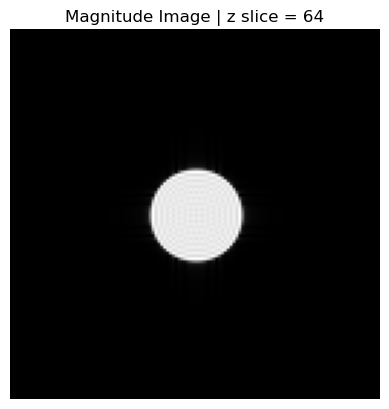

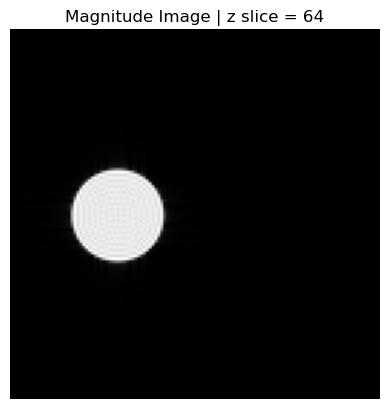

In [26]:
img_original = ksp_to_image(ksp_cylinder)
img_shifted = ksp_to_image(ksp_cylinder_shifted)

plot_img_magnitude(img_original)
plot_img_magnitude(img_shifted)

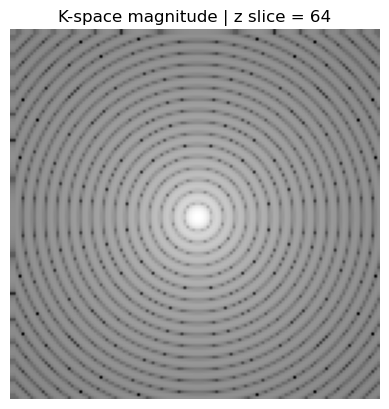

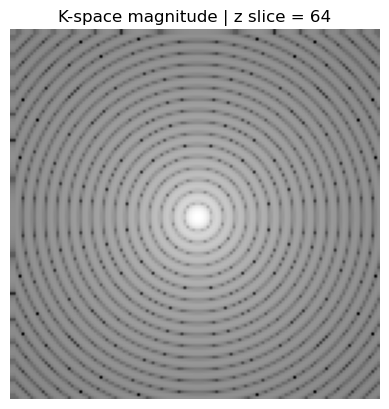

In [27]:
ksp1 = ifftshift(ifftn(fftshift(img_original)))
ksp2 = ifftshift(ifftn(fftshift(img_shifted)))
plot_ksp_magnitude(ksp1)
plot_ksp_magnitude(ksp2)

phase = (0.007812499999999778+4.735795089416683e-16j)
(128, 128, 128)


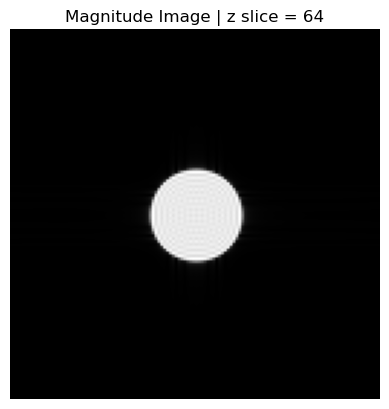

In [30]:
shift_pixels_coord=(0,100)
sx, sy = shift_pixels_coord
kmax=0.5

unshifted_ksp = shift_pixels(ksp2, kmax=0.5, shift_pixels_coord=(shift_pixels_coord))
img_unshifted = ksp_to_image(unshifted_ksp)
plot_img_magnitude(img_unshifted)